# Desafio Cientista de Dados - Análise e Predição de Churn Rate
### Candidato: Vinícius Marzall Lippel

Primeiramente importamos as bibliotecas que serão necessárias

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras

from imblearn.over_sampling import SMOTE

# Análise dos dados

Criamos um DataFrame a partir do arquivo Abandono_clientes.csv

In [307]:
df = pd.read_csv('Abandono_clientes.csv')

Verificamos seu formato e os tipos de dados armazenados para cada cliente

In [2]:
print(df.shape)
df.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


A coluna Exited, que tentaremos prever, é constituída por 0 ou 1, onde 1 indica que o cliente abandonou o serviço. **Portanto, este é um problema de classificação binária.**

No gráfico abaixo podemos verificar que 20.4% dos clientes abandonaram o serviço, enquanto 79.6% permaneceram. Isto indica uma base de dados desbalanceada, que deverá ser tratada posteriormente para o bom funcionamento dos modelos de Machine Learning

0    7963
1    2037
Name: Exited, dtype: int64


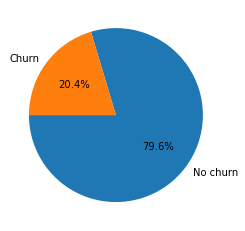

In [6]:
churn_rate = df['Exited'].value_counts()

plt.pie(churn_rate, 
        labels=['No churn','Churn'], 
        startangle=180, 
        autopct='%1.1f%%')

print(churn_rate)
plt.show()

Definimos uma função hist() para criarmos histogramas, assim podemos analisar a correlação de algumas colunas com a quantidade de Churn   

In [328]:
def hist(column):
    plt.hist([df[df.Exited == 0].loc[:, column], df[df.Exited == 1].loc[:, column]], label=['No Churn', 'Churn'])
    plt.legend()
    plt.show()

##### Podemos formular algumas hipóteses analisando estes histogramas:

A fidelidade do cliente parece ter uma pequena influência em sua probabilidade de saída

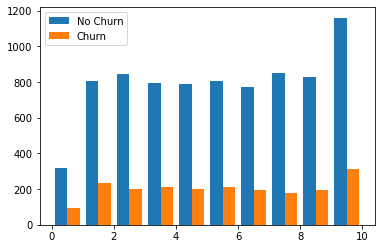

In [330]:
hist('Tenure')

O balanço não parece ter muita influência no churn

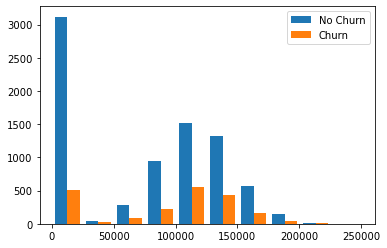

In [331]:
hist('Balance')

Clientes entre 40 e 60 anos possuem uma maior probabilidade de saída

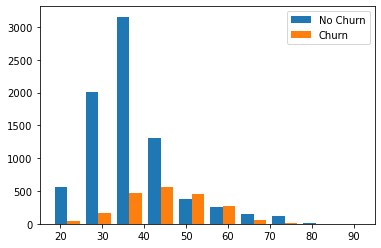

In [335]:
hist('Age')

Clientes da alemanha possuem uma maior probabilidade de abandonar o serviço

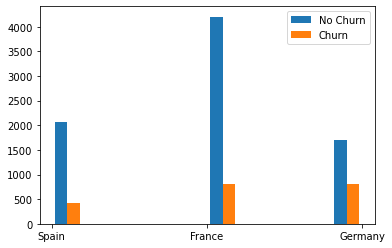

In [333]:
hist('Geography')

Clientes com apenas 2 produtos possuem a menor incidência de churn proporcionalmente

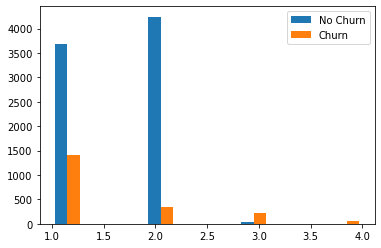

In [334]:
hist('NumOfProducts')

É de suma importância compreendermos estas estatísticas, pois são elas que irão influenciar os modelos preditivos a encontrarem os padrões que podem indicar se cliente está ou não prestes a deixar o serviço. Um cliente francês de 30 anos que adquiriu 2 produtos possui uma chance muito menor de saída que um alemão de 50 anos que adquiriu 3 produtos, e o modelo deve ser capaz de prever isso.

## Tratamento dos dados

Podemos excluir as colunas RowNumber, CustomerId e Surname, pois referem-se apenas à dados de cadastro, não possuindo influência na decisão do cliente de abandonar ou não o serviço, e, portanto, sem utilidade para um modelo preditivo

In [3]:
df.drop(df.columns[[0, 1, 2]], axis = 1, inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Verificamos se alguma coluna possui dados nulos que precisam ser tratados. Neste caso, todas as colunas estão devidamente preenchidas

In [5]:
df.isna().any()

CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

Alteramos a coluna Gender para, ao invés de "Female" ou "Male", armazenar 1 ou 0 respectivamente

In [9]:
df['Gender'].replace({'Female':1, 'Male':0}, inplace = True)
df['Gender'].unique()

array([1, 0], dtype=int64)

Como podemos verificar abaixo, a coluna Geography possui três valores únicos de dados armazenados em forma de texto 

In [308]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

Utilizamos a função get_dummies() do Pandas para criar três novas colunas: Geography_France, Geography_Germany e Geography_Spain, que receberão o valor 1 caso o cliente seja do respectivo país e 0 caso contário.

In [10]:
df = pd.get_dummies(data=df, columns=['Geography'])
df.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype='object')

Agora todos os valores armazenados na tabela são númericos, facilitando sua aplicação em um modelo preditivo

In [11]:
df.dtypes

CreditScore            int64
Gender                 int64
Age                    int64
Tenure                 int64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Exited                 int64
Geography_France       uint8
Geography_Germany      uint8
Geography_Spain        uint8
dtype: object

No entando, alguns valores ainda precisam ser colocados em escala, isto é, entre 0 e 1. Fazemos isto chamando a função MinMaxScaler() para as colunas que ainda não estão entre 0 e 1.

In [13]:
to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = MinMaxScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])

df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,0.538,1,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,1,0,0
1,0.516,1,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,0,0,1
2,0.304,1,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,1,0,0
3,0.698,1,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,1,0,0
4,1.000,1,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,0,0,1


Criamos dois novos DataFrames: "x", contendo os valores de todas as colunas da tabela menos Exited, e "y", contendo os valores da coluna Exited. Isto é necessário para que o modelo possa ser treinado e testado sem saber os valores de Exited préviamente

In [257]:
x = df.drop('Exited', axis='columns')
y = df['Exited']

Abaixo temos a definição da função para a criação de um modelo de predição utilizando Redes Neurais Artificiais 

In [310]:
#Recebemos como parâmetros x e y de treinamento e de testes
def ann(x_train, y_train, x_test, y_test):
    
    #Criamos um modelo de RNA utilizando Keras, da biblioteca TensorFlow
    model = keras.Sequential([
        #Definimos as camadas de nerônios com droput de 20% para cada
        keras.layers.Dense(12, input_shape=(12,), activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(7, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid'), 
    ])
    
    #Compilados o modelo
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    #Treinamos o modelo utilizando x e y de treinamento, executando 70 epochs
    model.fit(x_train, y_train, epochs=70)
    
    #Prevemos e arredondamos (para 0 ou 1) os valores de Exited para x de teste
    y_pred = model.predict(x_test)
    y_pred = np.round(y_pred)
    
    #Verificamos os resultados comparando y de teste com y previsto
    print(classification_report(y_test, y_pred))
    
    return y_pred

Rodamos a Rede Neural para o DataFrame ainda desbalanceado. Primeiramente separamos x e y em x_train, x_test, y_train e y_test utilizando train_test_split(), passando então estes DataFrames para ann(). Nesta execução, a pontuação F1 para a predição de 1 (positiva para churn) foi de apenas 0.48, enquanto para 0 foi de 0.91. Isto ocorre pelo desbalanceamento do DataFrame, pois existem muito mais linhas com Exited = 0 para que o modelo possa treinar

In [314]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)

y_pred = ann(x_train, y_train, x_test, y_test)

Epoch 1/70
250/250 [==============================] - 0s 1ms/step - loss: 0.5834 - accuracy: 0.7115
Epoch 2/70
250/250 [==============================] - 0s 1ms/step - loss: 0.4983 - accuracy: 0.7934
Epoch 3/70
250/250 [==============================] - 0s 991us/step - loss: 0.4857 - accuracy: 0.7956
Epoch 4/70
250/250 [==============================] - 0s 951us/step - loss: 0.4793 - accuracy: 0.7956
Epoch 5/70
250/250 [==============================] - 0s 1ms/step - loss: 0.4745 - accuracy: 0.7970
Epoch 6/70
250/250 [==============================] - 0s 983us/step - loss: 0.4675 - accuracy: 0.7999
Epoch 7/70
250/250 [==============================] - 0s 991us/step - loss: 0.4582 - accuracy: 0.8039
Epoch 8/70
250/250 [==============================] - 0s 1ms/step - loss: 0.4528 - accuracy: 0.8102
Epoch 9/70
250/250 [==============================] - 0s 943us/step - loss: 0.4468 - accuracy: 0.8101
Epoch 10/70
250/250 [==============================] - 0s 943us/step - loss: 0.4452 - accu

Para resolver este problema, podemos utilizar técnicas de undersampling ou oversampling para igualar o número de classificações positivas e negativas. Neste caso utilizamos a técnica de SMOTE (Synthetic Minority Oversampling Technique), um tipo de oversampling onde criam-se versões sintéticas dos dados baseados na classe minoritária, para igualá-la ao número de dados da classe majoritária. Neste caso, a pontuação F1 para a previsão de churn passou para 59%, a precisão diminuiu para 49% e o recall aumentou para 73%.

In [262]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)

smt = SMOTE(sampling_strategy = 'minority')
x_smote, y_smote = smt.fit_resample(x_train, y_train)

y_pred = ann(x_smote, y_smote, x_test, y_test)

Epoch 1/70
398/398 [==============================] - 0s 1ms/step - loss: 0.6876 - accuracy: 0.5421
Epoch 2/70
398/398 [==============================] - 0s 1ms/step - loss: 0.6511 - accuracy: 0.6165
Epoch 3/70
398/398 [==============================] - 0s 987us/step - loss: 0.6257 - accuracy: 0.6559
Epoch 4/70
398/398 [==============================] - 0s 957us/step - loss: 0.6027 - accuracy: 0.6731
Epoch 5/70
398/398 [==============================] - 1s 1ms/step - loss: 0.5842 - accuracy: 0.6924
Epoch 6/70
398/398 [==============================] - 0s 1ms/step - loss: 0.5727 - accuracy: 0.7030
Epoch 7/70
398/398 [==============================] - 0s 1ms/step - loss: 0.5691 - accuracy: 0.7094
Epoch 8/70
398/398 [==============================] - 0s 929us/step - loss: 0.5608 - accuracy: 0.7151
Epoch 9/70
398/398 [==============================] - 1s 1ms/step - loss: 0.5597 - accuracy: 0.7212
Epoch 10/70
398/398 [==============================] - 1s 1ms/step - loss: 0.5552 - accuracy: 

Outra técnica bastante utilizada para a predição de dados de classificação binária é a Random Forest Classifier. Nela, uma série de árvores de decisão são criadas para tentar prever o resultado esperado, a previsão obtida no maior número de árvores é passada como o modelo de saída. Neste caso, aplicamos novamente a técnica de SMOTE para balancear o DataFrame, pois desta forma os resultados obtidos são mais precisos. 

In [263]:
#Separação entre x e y de treino e de teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

#Balanceamento dos dataframes de treinamento com SMOTE
smt = SMOTE(sampling_strategy=1, random_state=6)
x_smote, y_smote = smt.fit_resample(x_train, y_train)

#Verificando balanceamento
print (np.unique(y_train, return_counts=True) , np.bincount(y_smote))

#Criando modelo de Random Forest Classifier
model = RandomForestClassifier()

#Treinando modelo com x_smote e y_smote 
model.fit(x_smote, y_smote)

#Prevendo valores de y
y_pred = model.predict(x_test)

#Verificando preformance do modelo
print(classification_report(y_test, y_pred))

(array([0, 1], dtype=int64), array([6370, 1630], dtype=int64)) [6370 6370]


              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1593
           1       0.63      0.61      0.62       407

    accuracy                           0.85      2000
   macro avg       0.77      0.76      0.76      2000
weighted avg       0.85      0.85      0.85      2000



Abaixo prevemos os valores da coluna Exited para o arquivo Abandono_teste.csv. O modelo de predição utilizado foi o de Random Forest Classifier com o DataFrame balanceado, pois foi o que obteve a melhor performance dentre as técnicas testadas

In [306]:
#Leitura do arquivo Abandono_teste.csv
df_test = pd.read_csv('Abandono_teste.csv', sep=';')

#Tratando o DataFrame para poder ser utilizada pelo modelo
df_test.drop(df_test.columns[[0, 1, 2]], axis = 1, inplace=True)
df_test['Gender'].replace({'Female':1, 'Male':0}, inplace = True)
df_test = pd.get_dummies(data=df_test, columns=['Geography'])
df_test[to_scale] = scaler.fit_transform(df_test[to_scale])

#Realizando a previsão utilizando RFA
df_test_pred = model.predict(df_test)

#Criando o DataFrame final contendo o número da linha e o valor de Exited previsto
row_num = np.array(range(len(df_test_pred)))
df_final = np.column_stack((row_num, df_test_pred))
df_final = pd.DataFrame(df_final)

#Criando planilha com df_final
df_final.to_excel(excel_writer = "Abandono_teste_prediction.xlsx", 
                  header = ['rowNumber', 'predictedValues'], index = False)

#Mostrando df_final
print(df_final)

       0  1
0      0  0
1      1  0
2      2  0
3      3  0
4      4  0
..   ... ..
995  995  0
996  996  1
997  997  1
998  998  0
999  999  0

[1000 rows x 2 columns]
